In [1]:
%uv pip install datasets diffusers

Using Python 3.12.6 environment at: /usr/local
Resolved 37 packages in 226ms
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
dill       ------------------------------     0 B/116.86 KiB
⠙ Preparing packages... (0/5)
dill       ------------------------------ 14.89 KiB/116.86 KiB
⠙ Preparing packages... (0/5)
dill       ------------------------------ 14.89 KiB/116.86 KiB
⠙ Preparing packages... (0/5)
dill       ------------------------------ 14.89 KiB/116.86 KiB
multiprocess ------------------------------ 16.00 KiB/143.30 KiB
⠙ Preparing packages... (0/5)
dill       ------------------------------ 14.89 KiB/116.86 KiB
multiprocess ------------------------------ 16.00 KiB/143.30 KiB
⠙ Preparing packages... (0/5)
dill       ------------------------------ 14.89 KiB/116.86 KiB
multiprocess ------------------------------ 16.00 KiB/143.30 KiB
xxhash     ------------------------------ 16.00 KiB/189.82 KiB
⠙ Preparing packages... (0/5)
dill       ------------------------------ 14.89 K

In [2]:
from datasets import load_dataset
import torch
import numpy as np

In [3]:
dataset = load_dataset("yesidobyte/nsfw1024", split="train")

Reg1024.zip:   0%|          | 0.00/3.74G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4289 [00:00<?, ? examples/s]

In [4]:
from torchvision import transforms

In [5]:
image_size = 128

In [6]:
preprocess = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [7]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

In [8]:
dataset.set_transform(transform)

In [9]:
batch_size = 300
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, pin_memory=True,num_workers=8, prefetch_factor=2, shuffle=True
)

In [10]:
import matplotlib.pyplot as plt
def show_batch(batch, batch_size=8, nrows=2):
    ncols = batch_size // nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten()

    for j in range(batch_size):
        img = batch[j]
        img = (img / 2 + 0.5).clamp(0, 1)
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        
        axes[j].imshow(img)
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [11]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

In [12]:
# scheduler = DDPMScheduler(
#     num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
# )
# timesteps = torch.linspace(0, 999, 8).long()
# x = batch["images"][:8]
# noise = torch.rand_like(x)
# noised_x = scheduler.add_noise(x, noise, timesteps)
# show_batch(noised_x, batch_size=8)

In [13]:
from diffusers import UNet2DModel
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
device

'cuda'

In [15]:
model = UNet2DModel(
    in_channels=3,
    sample_size=128,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

"DownBlock2D": convolution + downsample (stride=2)

"AttnDownBlock2D": convolution + attention layer + downsample

Ở đây, encoder có 2 block thường + 2 block attention → cho phép U-Net capture long-range dependencies (rất quan trọng trong diffusion model).

In [16]:
# with torch.inference_mode():
#     out = model(noised_x.to(device), timestep=timesteps.to(device)).sample
# print(noised_x.shape, out.shape)

In [17]:
from torch.nn import functional as F

In [18]:
num_epochs = 50
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []

In [19]:
from tqdm.auto import tqdm

# Training loop với progress bars
for epoch in range(num_epochs):
    # Progress bar cho từng epoch
    epoch_bar = tqdm(train_dataloader, 
                     desc=f"Epoch {epoch+1}/{num_epochs}",
                     leave=True)
    
    epoch_losses = []
    
    for batch in epoch_bar:
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        
        timesteps = torch.randint(
            0, 
            scheduler.config.num_train_timesteps, 
            (clean_images.shape[0],),
            device=device
        ).long()
        
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(noise_pred, noise)
        epoch_losses.append(loss.item())
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Cập nhật progress bar với loss hiện tại
        epoch_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{sum(epoch_losses)/len(epoch_losses):.4f}'
        })
    
    # In loss trung bình của epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1} completed - Average Loss: {avg_epoch_loss:.4f}")

Epoch 1/50:   0%|          | 0/15 [00:01<?, ?it/s]

Epoch 1 completed - Average Loss: 0.5888


Epoch 2/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Exception ignored in: Exception ignored in: 
if w.is_alive():    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ign

Epoch 2 completed - Average Loss: 0.1874


Epoch 3/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Traceback (most recent call last):
Exception ignored in: Exception ignored in: 



  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
    


Epoch 3 completed - Average Loss: 0.1001


Epoch 4/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Exception ignored in: Traceback (most recent call last):

Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:     

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Epoch 4 completed - Average Loss: 0.0765


Epoch 5/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>







Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Epoch 5 completed - Average Loss: 0.0675


Epoch 6/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__





<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
Traceback (most recent call last):
    Traceback (most recent call last):
Traceback (most recent call last):

Epoch 6 completed - Average Loss: 0.0620


Epoch 7/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>





Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/datal

Epoch 7 completed - Average Loss: 0.0541


Epoch 8/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


  File "/usr/local/lib/python3.12/site

Epoch 8 completed - Average Loss: 0.0479


Epoch 9/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>



  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Exception ignored in: 
Traceback (most recent call last):
Tr

Epoch 9 completed - Average Loss: 0.0437


Epoch 10/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

Traceback (most recent call last):


Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Tra

Epoch 10 completed - Average Loss: 0.0403


Epoch 11/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>        <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>self._shutdown_workers()self._shutdown_workers()



Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py"

Epoch 11 completed - Average Loss: 0.0408


Epoch 12/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
    
Exception ignored in: self._shutdown_workers()Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in: 
Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        Traceback (most recent call last

Epoch 12 completed - Average Loss: 0.0368


Epoch 13/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>self._shutdown_workers()

Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>    <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

if w.is_alive():
    Traceback (most recent call last):

self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


Epoch 13 completed - Average Loss: 0.0331


Epoch 14/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in: 
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0> self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in:  

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in:    File "/usr/local/lib/

Epoch 14 completed - Average Loss: 0.0328


Epoch 15/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>      File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>if w.is_alive():
    

Traceback (most recent call last):
self._shutdown_workers() Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Epoch 15 completed - Average Loss: 0.0296


Epoch 16/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
    self._shutdown_workers()Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


      File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    

Epoch 16 completed - Average Loss: 0.0293


Epoch 17/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in:     

self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in: Traceback (most recent call last):


Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-pack

Epoch 17 completed - Average Loss: 0.0282


Epoch 18/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: 

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call last):
Exception ignored in:     self._shutdown_workers()  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>self._shutdown_workers()
    

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()Exception ignored in:   Fil

Epoch 18 completed - Average Loss: 0.0275


Epoch 19/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
          File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()self._shutdown_workers()    

self._shutdown_workers()  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

   

Epoch 19 completed - Average Loss: 0.0245


Epoch 20/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():Exception ignored in:       F

Epoch 20 completed - Average Loss: 0.0249


Epoch 21/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: 
Traceback (most recent call last):
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Exception ignored in: 
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>self

Epoch 21 completed - Average Loss: 0.0234


Epoch 22/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>      File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

self._shutdown_workers()Traceback (most recent call last):
    
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: self._sh

Epoch 22 completed - Average Loss: 0.0221


Epoch 23/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>      File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/uti

Epoch 23 completed - Average Loss: 0.0214


Epoch 24/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>


Exception ignored in: Traceback (most recent call last):
 Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

     Traceback (most recent call last):
    self._shutdown_wo

Epoch 24 completed - Average Loss: 0.0218


Epoch 25/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Exception ignored in:     
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Exception ignored in: self._shutdown_work

Epoch 25 completed - Average Loss: 0.0198


Epoch 26/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
    
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()Exception ignored in: Traceback (most recent call last):
    
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>if w.is_alive():  File "/usr/local/lib/python3.12/si

Epoch 26 completed - Average Loss: 0.0211


Epoch 27/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>




Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packa

Epoch 27 completed - Average Loss: 0.0204


Epoch 28/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in: 
        <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__


Traceback (most recent call last):
Exception ignored in:       File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_wo

Epoch 28 completed - Average Loss: 0.0193


Epoch 29/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>




<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, 

Epoch 29 completed - Average Loss: 0.0188


Epoch 30/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    Exception ignored in:   File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
    
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()Traceback (most recent call last):

      File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
self._s

Epoch 30 completed - Average Loss: 0.0187


Epoch 31/50:   0%|          | 0/15 [00:01<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0><function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>

<function _MultiProcessingDataLoaderIter.__del__ at 0x2a702f6163e0>
Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()    

KeyboardInterrupt: 

     ^ 
^   ^^^assert self._parent_pid == os.getpid(), 'can only test a child process'   File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

if w.is_alive(): ^   ^  ^^^
   File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      ^ ^   ^^^      assert self._parent_pid == os.getpid(), 'can only test a child process'   ^  ^  ^^
  assert self._parent_pid == os.getpid(), 'can only test a child process'
   ^  ^  ^  File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^
^    
  ^
 ^      ^^      File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  ^   File "/usr/local/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^assert self._parent_pid == os.getpid(), 'can only test a child process'  ^^         ^     ^^
  ^ ^   assert self._parent_pid == os.getpid(), 'can only test a child process'^^^assert self._parent_pid == os.getpid(), 'can only test a child

In [20]:
checkpoint_path = "nsfw_unet_epoch30.pth"
torch.save({
    'epoch': 30,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, checkpoint_path)

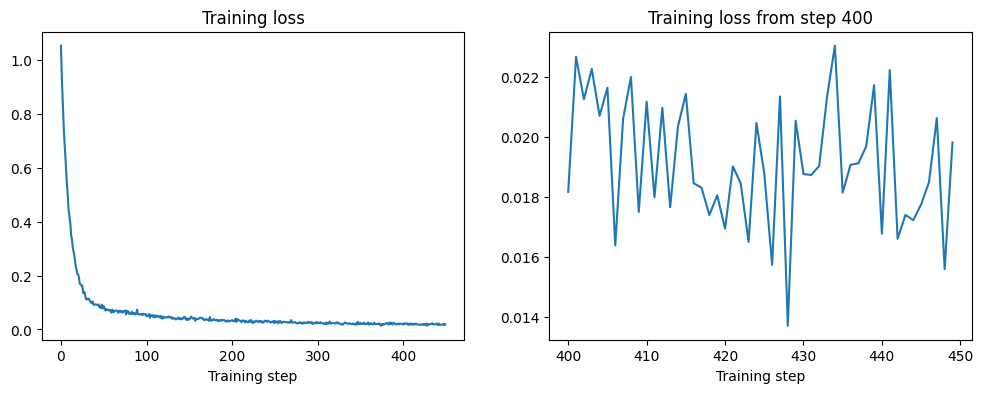

In [21]:
from matplotlib import pyplot as plt
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")
plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

In [22]:
from diffusers import DDPMPipeline
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images

  0%|          | 0/1000 [00:00<?, ?it/s]

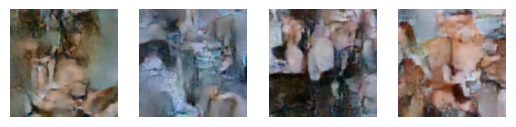

In [23]:
ims = np.array(ims)
for i in range(ims.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(ims[i])
    plt.axis('off')